In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import folium
import geopy
import geopandas as gpd

In [6]:
df_tw = pd.read_csv('../Data/Twitter_LDA.csv')
df_tw = df_tw.drop(df_tw.keys()[0], axis=1)
array = [1, 6]
df_tw = df_tw.loc[~df_tw.Topic_key_word.isin(array)].reset_index(drop=True)
df_tw = df_tw[~(df_tw['Greater Capital City'].str[1] == 'r')]

def labeling(x):
    if x < 0 and x >= -2:
        return 'negative'
    elif x < -2:
        return 'very negative'
    elif x==0:
        return 'neutral'
    elif x > 0 and x <= 2:
        return 'positive'
    else:
        return 'very positive'
df_tw["sentiment_la"]=df_tw["sentiment"].map(lambda x: labeling(x))

df_tw["Latitude"] = (df_tw["bottom"] + df_tw["top"])/2
df_tw["Longitude"] = (df_tw["left"] + df_tw["right"])/2

df_tw.to_csv('../Data/twiter_topic.csv')

In [7]:
df_twall = pd.read_csv('../Data/twitter_clean.csv')
df_twall = df_twall.drop(df_tw.keys()[0], axis=1)
df_twall["Latitude"] = (df_twall["bottom"] + df_twall["top"])/2
df_twall["Longitude"] = (df_twall["left"] + df_twall["right"])/2

The number of positive is 973101: 0.4018755273294488
The number of very positive is 413: 0.000170562554952736
The number of neutral is 947741: 0.3914022430834406
The number of negative is 499873: 0.20643974826123246
The number of very negative is 271: 0.00011191877092540305


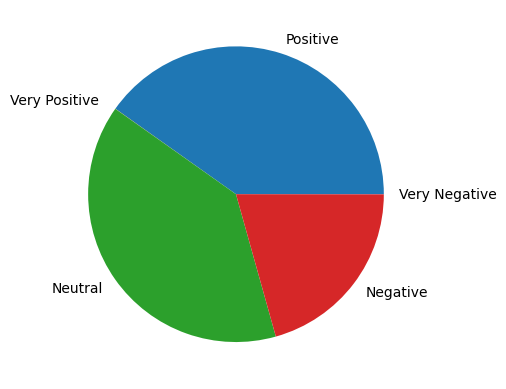

In [8]:
df_twall["sentiment_la"]=df_twall["sentiment"].map(lambda x: labeling(x))
num_total = len(df_twall)
num_pos = len(df_twall[(df_twall['sentiment_la']=='positive')])
num_vpos = len(df_twall[(df_twall['sentiment_la']=='very positive')])
num_neu = len(df_twall[(df_twall['sentiment_la']=='neutral')])
num_neg = len(df_twall[(df_twall['sentiment_la']=='negative')])
num_vneg = len(df_twall[(df_twall['sentiment_la']=='very negative')])

print('The number of positive is ' + str(num_pos) + ": " + str(num_pos/num_total))
print('The number of very positive is ' + str(num_vpos) + ": " + str(num_vpos/num_total))
print('The number of neutral is ' + str(num_neu) + ": " + str(num_neu/num_total))
print('The number of negative is ' + str(num_neg) + ": " + str(num_neg/num_total))
print('The number of very negative is ' + str(num_vneg) + ": " + str(num_vneg/num_total))
y = np.array([num_pos, num_vpos, num_neu, num_neg, num_vneg])
mylabels = ["Positive", "Very Positive ", "Neutral", "Negative", "Very Negative"]
plt.pie(y, labels = mylabels)
plt.show()

In [99]:
city = "brisbane"
# get location
locator = geopy.geocoders.Nominatim(user_agent="My app") 
city = locator.geocode(city)
location = [city.latitude, city.longitude]
print(city, "\n[lat, long]:", location)

Brisbane City, Queensland, Australia 
[lat, long]: [-27.4689682, 153.0234991]


In [13]:
sf_gcc = gpd.read_file("../Data/gcc_sf/GCCSA_2021_AUST_GDA2020.shp")
sf_gcc['Greater Capital City'] = sf_gcc['GCC_CODE21'].str.lower()
col = ['Greater Capital City', 'geometry']
sf_gcc1 = sf_gcc[col]
df_twall_sf = df_twall.merge(sf_gcc1, left_on="Greater Capital City", right_on="Greater Capital City")
df_tw_sf = df_tw.merge(sf_gcc1, left_on="Greater Capital City", right_on="Greater Capital City")

gdf_gcc = gpd.GeoDataFrame(sf_gcc)
geoJSON_gcc = gdf_gcc[['Greater Capital City', 'geometry']].drop_duplicates('Greater Capital City').to_json()

In [89]:
sf_sa4 = gpd.read_file("../Data/sa4_sf/SA4_2021_AUST_GDA2020.shp")
sf_sa4['Greater Capital City'] = sf_sa4['GCC_CODE21'].str.lower()
col = ['Greater Capital City', 'geometry', 'SA4_CODE21']
sf_sa4_ = sf_sa4[col]
sf_sa4_['sa4_code'] = sf_sa4_['SA4_CODE21']
sf_sa4_ = sf_sa4_[pd.to_numeric(sf_sa4_['sa4_code'], errors='coerce').notnull()]
sf_sa4_['sa4_code'] = sf_sa4_['sa4_code'].astype(np.int64)

df_mel_sd = pd.read_csv('../Data/mel_sd.csv')
df_mel_sd['sa4_code'] = df_mel_sd[' sa4_code_2016']
df_mel_sd = df_mel_sd.merge(sf_sa4_, left_on="sa4_code", right_on="sa4_code")
gdf_mel = gpd.GeoDataFrame(df_mel_sd)
geoJSON_mel = gdf_mel[['sa4_code', 'geometry']].drop_duplicates('sa4_code').to_json()

df_bri_sd = pd.read_csv('../Data/bri_sd.csv')
df_bri_sd['sa4_code'] = df_bri_sd[' sa4_code_2016']
df_bri_sd = df_bri_sd.merge(sf_sa4_, left_on="sa4_code", right_on="sa4_code")
gdf_bri = gpd.GeoDataFrame(df_bri_sd)
geoJSON_bri = gdf_bri[['sa4_code', 'geometry']].drop_duplicates('sa4_code').to_json()

/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [14]:
m_Twitterall = folium.Map(location=[-20.81,124.96], zoom_start=5)
c = folium.Choropleth(
    geo_data = geoJSON_gcc,
    name = 'choropleth',
    data = df_tw_sf,
    columns = ['Greater Capital City','sentiment'],
    key_on= 'feature.properties.Greater Capital City',
    fill_color = 'YlOrRd',
    nan_fill_color = 'white',
    legend_name = 'sentiment'
)
c.add_to(m_Twitterall)
m_Twitterall.save('../Data/Twitter_all.html')

In [92]:
df_mel_sd.keys()

Index(['Unnamed: 0', 'As at 30 June, family tax benefit B',
       'disability support ', ' yr', 'rent assistant ', ' sa4_code_2016',
       ' sa4_name_2016', 'Youth allowance ', 'family tax A benefit ',
       'sa4_code', 'Greater Capital City', 'geometry', 'SA4_CODE21'],
      dtype='object')

In [93]:
m_mel = folium.Map(location=[-37.81,144.96], zoom_start=9)
c = folium.Choropleth(
    geo_data = geoJSON_mel,
    name = 'choropleth',
    data = df_mel_sd,
    columns = ['sa4_code','As at 30 June, family tax benefit B'],
    key_on= 'feature.properties.sa4_code',
    fill_color = 'YlOrRd',
    nan_fill_color = 'white',
    legend_name = 'As at 30 June, family tax benefit B'
)
c.add_to(m_mel)

In [100]:
m_bri = folium.Map(location=[-27.4689682, 153.0234991], zoom_start=9)
c = folium.Choropleth(
    geo_data = geoJSON_bri,
    name = 'choropleth',
    data = df_bri_sd,
    columns = ['sa4_code','As at 30 June, family tax benefit B'],
    key_on= 'feature.properties.sa4_code',
    fill_color = 'YlOrRd',
    nan_fill_color = 'white',
    legend_name = 'As at 30 June, family tax benefit B'
)
c.add_to(m_bri)

In [188]:
df_tw_mel = df_tw.loc[df_tw['gcc']=='melbourne']
df_tw_mel_eg = df_tw_mel.loc[(df_tw_mel['sentiment'] < -1) | (df_tw_mel['sentiment'] > 1)]
df_tw_mel_eg.loc[df_tw_mel_eg["sentiment"]>0, ["color"]] = "More_positive"
df_tw_mel_eg.loc[df_tw_mel_eg["sentiment"]<0, ["color"]] = "More_negative"


In [189]:
colors = {'More_negative' : 'red', 'More_positive' : 'blue'}

m_mel_eg = folium.Map(location=[-38.043995, 145.264296], zoom_start=11)

df_tw_mel_eg.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                                              radius=3, fill_color=colors[row['color']])
                                             .add_to(m_mel_eg), axis=1)

322577    <folium.vector_layers.CircleMarker object at 0...
322607    <folium.vector_layers.CircleMarker object at 0...
322687    <folium.vector_layers.CircleMarker object at 0...
322831    <folium.vector_layers.CircleMarker object at 0...
322832    <folium.vector_layers.CircleMarker object at 0...
                                ...                        
585210    <folium.vector_layers.CircleMarker object at 0...
585263    <folium.vector_layers.CircleMarker object at 0...
585682    <folium.vector_layers.CircleMarker object at 0...
585721    <folium.vector_layers.CircleMarker object at 0...
585766    <folium.vector_layers.CircleMarker object at 0...
Length: 1780, dtype: object

In [191]:
df_tw_mel_eg

,author_id,cleaned_text,sentiment,gcc,left,bottom,right,top,Language,Greater Capital City,Topic_key_word,sentiment_la,Latitude,Longitude,color
322577,1394844978891792385,your|gif|funny|lol,1.125000,melbourne,144.593742,-38.433859,145.512529,-37.511274,en,2gmel,4,positive,-37.972567,145.053135,More_positive
322607,38140504,nice|one,1.250000,melbourne,144.593742,-38.433859,145.512529,-37.511274,en,2gmel,2,positive,-37.972567,145.053135,More_positive
322687,1471735216368603137,thanks|lovely,1.250000,melbourne,144.593742,-38.433859,145.512529,-37.511274,en,2gmel,7,positive,-37.972567,145.053135,More_positive
322831,2924893094,thank|you,1.250000,melbourne,144.593742,-38.433859,145.512529,-37.511274,en,2gmel,7,positive,-37.972567,145.053135,More_positive
322832,2924893094,thanks|hun,1.250000,melbourne,144.593742,-38.433859,145.512529,-37.511274,en,2gmel,7,positive,-37.972567,145.053135,More_positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585210,15510386,thanks|mif,1.250000,melbourne,144.593742,-38.433859,145.512529,-37.511274,en,2gmel,7,positive,-37.972567,145.053135,More_positive
585263,130948141,amazing|photos|timeless,1.333333,melbourne,144.593742,-38.433859,145.512529,-37.511274,en,2gmel,4,positive,-37.972567,145.053135,More_positive
585682,3300789416,amazing,1.333333,melbourne,144.593742,-38.433859,145.512529,-37.511274,en,2gmel,10,positive,-37.972567,145.053135,More_positive
585721,1192608117164408832,lol|soul,1.500000,melbourne,144.593742,-38.433859,145.512529,-37.511274,en,2gmel,4,positive,-37.972567,145.053135,More_positive


In [190]:
m_mel_eg